In [ ]:
#extraction of data 
import os
base_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus'
train_en_path = os.path.join(base_path, 'train.en')
test_en_path = os.path.join(base_path, 'test.en')
dev_en_path = os.path.join(base_path, 'dev.en')
train_fr_path = os.path.join(base_path, 'train.fr')
test_fr_path = os.path.join(base_path, 'test.fr')
dev_fr_path = os.path.join(base_path, 'dev.fr')
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    return data
train_en = load_data(train_en_path)
test_en = load_data(test_en_path)
dev_en = load_data(dev_en_path)
train_fr = load_data(train_fr_path)
test_fr = load_data(test_fr_path)
dev_fr = load_data(dev_fr_path)
print(f"Number of English train sentences: {len(train_en)}")
print(f"Number of French train sentences: {len(train_fr)}")


Using device: cuda
Number of English train sentences: 30000
Number of French train sentences: 30000
Epoch 1, Training Loss: 9.4101, Validation Loss: 9.3777
Epoch 2, Training Loss: 9.3391, Validation Loss: 9.2589
Epoch 3, Training Loss: 9.2150, Validation Loss: 9.1078
Epoch 4, Training Loss: 9.0830, Validation Loss: 8.9756
Epoch 5, Training Loss: 8.9736, Validation Loss: 8.8736
Overall BLEU Score on test set: 0.1605


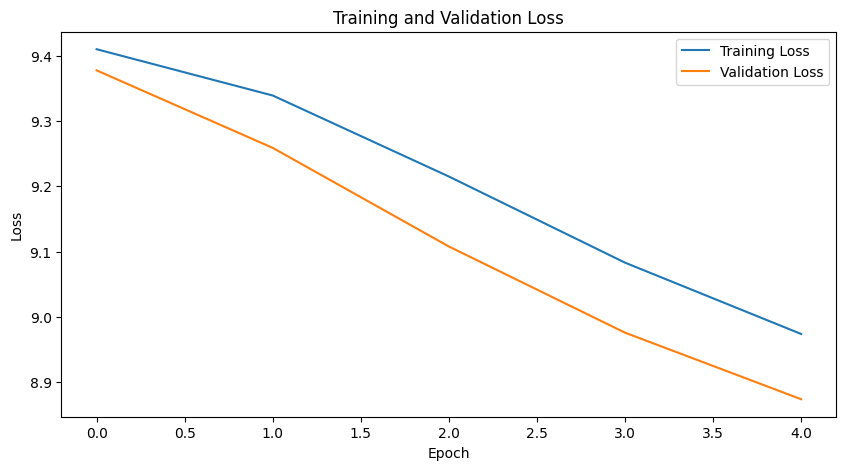

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import sentencepiece as spm
from nltk.translate.bleu_score import SmoothingFunction
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
random.seed(42)
torch.manual_seed(42)
base_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus'
train_en_path = os.path.join(base_path, 'train.en')
train_fr_path = os.path.join(base_path, 'train.fr')
dev_en_path = os.path.join(base_path, 'dev.en')
dev_fr_path = os.path.join(base_path, 'dev.fr')
test_en_path = os.path.join(base_path, 'test.en')
test_fr_path = os.path.join(base_path, 'test.fr')


def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    return data

train_en = load_data(train_en_path)
train_fr = load_data(train_fr_path)
dev_en = load_data(dev_en_path)
dev_fr = load_data(dev_fr_path)
test_en = load_data(test_en_path)
test_fr = load_data(test_fr_path)

print(f"Number of English train sentences: {len(train_en)}")
print(f"Number of French train sentences: {len(train_fr)}")

sp_model_prefix_en = 'spm_en'
sp_model_prefix_fr = 'spm_fr'

with open('train_subset.en', 'w', encoding='utf-8') as f:
    f.write("".join(train_en))

with open('train_subset.fr', 'w', encoding='utf-8') as f:
    f.write("".join(train_fr))

spm.SentencePieceTrainer.train(
    input='train_subset.en', 
    model_prefix=sp_model_prefix_en, 
    vocab_size=12000, 
    model_type='bpe',
    max_sentence_length=4096,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)
spm.SentencePieceTrainer.train(
    input='train_subset.fr', 
    model_prefix=sp_model_prefix_fr, 
    vocab_size=12000, 
    model_type='bpe',
    max_sentence_length=4096,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)

sp_en = spm.SentencePieceProcessor(model_file=f'{sp_model_prefix_en}.model')
sp_fr = spm.SentencePieceProcessor(model_file=f'{sp_model_prefix_fr}.model')

def encode_sentence(sp, sentence):
    return [sp.bos_id()] + sp.encode(sentence, out_type=int) + [sp.eos_id()]

def filter_and_pad_sequences(source_sequences, target_sequences, pad_index, max_len):
    filtered_pairs = [(src, tgt) for src, tgt in zip(source_sequences, target_sequences) 
                      if len(src) <= max_len and len(tgt) <= max_len]
    if not filtered_pairs:
        return [], []
    source_sequences, target_sequences = zip(*filtered_pairs)
    
    source_padded = [src + [pad_index] * (max_len - len(src)) for src in source_sequences]
    target_padded = [tgt + [pad_index] * (max_len - len(tgt)) for tgt in target_sequences]
    
    return source_padded, target_padded

d_model = 256
num_heads = 8
num_encoder_layers = 4
num_decoder_layers = 4
d_ff = 1024
dropout = 0.2
epochs = 5
max_len = 50
learning_rate = 0.0001
train_en_indices = [encode_sentence(sp_en, sent) for sent in train_en]
train_fr_indices = [encode_sentence(sp_fr, sent) for sent in train_fr]
train_en_padded, train_fr_padded = filter_and_pad_sequences(train_en_indices, train_fr_indices, sp_en.pad_id(), max_len)
train_en_tensor = torch.tensor(train_en_padded, dtype=torch.long)
train_fr_tensor = torch.tensor(train_fr_padded, dtype=torch.long)

class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data
        
    def __len__(self):
        return len(self.src_data)
        
    def __getitem__(self, index):
        return self.src_data[index], self.tgt_data[index]

train_dataset = TranslationDataset(train_en_tensor, train_fr_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
    
    def attention(self, q, k, v, mask=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k) 
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2) 
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)  
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = F.softmax(scores, dim=-1)
        return torch.matmul(attn_weights, v)
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        seq_len_q = q.size(1)
        seq_len_k = k.size(1)
        q = self.q_linear(q).view(batch_size, seq_len_q, self.num_heads, self.d_k).transpose(1,2)  
        k = self.k_linear(k).view(batch_size, seq_len_k, self.num_heads, self.d_k).transpose(1,2)  
        v = self.v_linear(v).view(batch_size, seq_len_k, self.num_heads, self.d_k).transpose(1,2)  
        
        attn_output = self.attention(q, k, v, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len_q, self.d_k * self.num_heads)
        return self.out_linear(attn_output)


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    
    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.encoder_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        attn_output = self.self_attention(x, x, x, tgt_mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        attn_output = self.encoder_attention(x, enc_output, enc_output, src_mask)
        x = x + self.dropout(attn_output)
        x = self.norm2(x)
        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.norm3(x)
        return x



class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.linear = nn.Linear(d_model, vocab_size)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return self.linear(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_encoder_layers, num_decoder_layers, num_heads, d_ff, dropout):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_encoder_layers, num_heads, d_ff, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_decoder_layers, num_heads, d_ff, dropout)
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        return dec_output


def prepare_dataset(en_sentences, fr_sentences, sp_en, sp_fr):
    en_indices = [encode_sentence(sp_en, sent) for sent in en_sentences]
    fr_indices = [encode_sentence(sp_fr, sent) for sent in fr_sentences]
    en_padded, fr_padded = filter_and_pad_sequences(en_indices, fr_indices, sp_en.pad_id(), max_len)
    en_tensor = torch.tensor(en_padded, dtype=torch.long)
    fr_tensor = torch.tensor(fr_padded, dtype=torch.long)
    dataset = TranslationDataset(en_tensor, fr_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    return loader

dev_loader = prepare_dataset(dev_en, dev_fr, sp_en, sp_fr)
test_loader = prepare_dataset(test_en, test_fr, sp_en, sp_fr)

def create_pad_mask(seq, pad_index):
    return (seq != pad_index).unsqueeze(1).unsqueeze(2)

def create_tgt_mask(tgt, pad_index):
    tgt_pad_mask = (tgt != pad_index).unsqueeze(1).unsqueeze(2)
    seq_len = tgt.size(1)
    subsequent_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=tgt.device))
    subsequent_mask = subsequent_mask.unsqueeze(0).unsqueeze(1)
    tgt_mask = tgt_pad_mask & subsequent_mask
    return tgt_mask

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0, std=math.sqrt(1.0 / module.embedding_dim))
        if module.padding_idx is not None:
            nn.init.constant_(module.weight[module.padding_idx], 0)
    elif isinstance(module, nn.LayerNorm):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
        
def noam_scheduler(step, warmup_steps, d_model):
    return (d_model ** -0.5) * min((step + 1) ** -0.5, (step + 1) * (warmup_steps ** -1.5))

model = Transformer(sp_en.vocab_size(), sp_fr.vocab_size(), d_model, num_encoder_layers, num_decoder_layers, num_heads, d_ff, dropout).to(device)
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss(ignore_index=sp_fr.pad_id())
warmup_steps = 4000  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: noam_scheduler(step, warmup_steps, d_model))

train_losses = []
val_losses = []

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            src_mask = create_pad_mask(src, sp_en.pad_id()).to(device)
            tgt_mask = create_tgt_mask(tgt_input, sp_fr.pad_id()).to(device)
            output = model(src, tgt_input, src_mask, tgt_mask)
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.contiguous().view(-1)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    return total_loss / len(val_loader)

fr_idx2word = {idx: sp_fr.id_to_piece(idx) for idx in range(sp_fr.vocab_size())}

def calculate_bleu_sentence_level(model, test_loader, sp_fr, fr_idx2word, output_file='testbleu.txt'):
    model.eval()
    with open(output_file, 'w', encoding='utf-8') as f:
        with torch.no_grad():
            for src, tgt in test_loader:
                src = src.to(device)
                tgt = tgt.to(device)
                batch_size = src.size(0)
                src_mask = create_pad_mask(src, sp_en.pad_id()).to(device)
                tgt_input = torch.full((batch_size, 1), sp_fr.bos_id(), dtype=torch.long, device=device)
                for _ in range(max_len):
                    tgt_mask = create_tgt_mask(tgt_input, sp_fr.pad_id()).to(device)
                    output = model(src, tgt_input, src_mask, tgt_mask)
                    next_token = output.argmax(dim=-1)[:, -1].unsqueeze(1)
                    tgt_input = torch.cat((tgt_input, next_token), dim=1)
                    if (next_token == sp_fr.eos_id()).all():
                        break
                for ref, hyp in zip(tgt.tolist(), tgt_input.tolist()):
                    ref_tokens = [fr_idx2word[token] for token in ref if token not in [sp_fr.pad_id(), sp_fr.bos_id()]]
                    hyp_tokens = [fr_idx2word.get(token, '<unk>') for token in hyp if token not in [sp_fr.pad_id(), sp_fr.bos_id(), sp_fr.eos_id()]]
                    bleu_score = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=SmoothingFunction().method4)
                    f.write(f"{' '.join(ref_tokens)} : {bleu_score:.4f}\n")
                    
def calculate_bleu(model, test_loader, sp_fr, fr_idx2word):
    model.eval()
    references = []
    hypotheses = []
    with torch.no_grad():
        for src, tgt in test_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            batch_size = src.size(0)
            src_mask = create_pad_mask(src, sp_en.pad_id()).to(device)
            tgt_input = torch.full((batch_size, 1), sp_fr.bos_id(), dtype=torch.long, device=device)
            for _ in range(max_len):
                tgt_mask = create_tgt_mask(tgt_input, sp_fr.pad_id()).to(device)
                output = model(src, tgt_input, src_mask, tgt_mask)
                next_token = output.argmax(dim=-1)[:, -1].unsqueeze(1)
                tgt_input = torch.cat((tgt_input, next_token), dim=1)
                if (next_token == sp_fr.eos_id()).all():
                    break
            for ref, hyp in zip(tgt.tolist(), tgt_input.tolist()):
                ref_tokens = [fr_idx2word[token] for token in ref if token not in [sp_fr.pad_id(), sp_fr.bos_id()]]
                hyp_tokens = [fr_idx2word.get(token, '<unk>') for token in hyp if token not in [sp_fr.pad_id(), sp_fr.bos_id(), sp_fr.eos_id()]]
                references.append([ref_tokens])
                hypotheses.append(hyp_tokens)
    smoothing_function = SmoothingFunction().method4
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing_function)
    return bleu_score

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, (src, tgt) in enumerate(train_loader):
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        src_mask = create_pad_mask(src, sp_en.pad_id()).to(device)
        tgt_mask = create_tgt_mask(tgt_input, sp_fr.pad_id()).to(device)
        optimizer.zero_grad()
        output = model(src, tgt_input, src_mask, tgt_mask)
        output = output.view(-1, output.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    val_loss = evaluate(model, dev_loader, criterion)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss) 
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")
calculate_bleu_sentence_level(model, test_loader, sp_fr, fr_idx2word, output_file='testbleu.txt')
overall_bleu_score = calculate_bleu(model, test_loader, sp_fr, fr_idx2word)
print(f"Overall BLEU Score on test set: {overall_bleu_score:.4f}")
model_save_path = "transformer_model.pt"
torch.save(model.state_dict(), model_save_path)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Using device: cuda
Number of English train sentences: 30000
Number of French train sentences: 30000
Training with config: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'num_heads': 4, 'd_model': 128, 'd_ff': 512, 'dropout': 0.1}
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 1, Training Loss: 9.3963, Validation Loss: 9.3930
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 2, Training Loss: 9.3899, Validation Loss: 9.3821
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 3, Training Loss: 9.3770, Validation Loss: 9.3647
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 4, Training Loss: 9.3589, Validation Loss: 9.3419
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 5, Training Loss: 9.3364, Validation Loss: 9.3156
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 6, Training Loss: 9.3136, Validation Loss: 9.2924
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 7, Training Loss: 9.2941, Validation Loss: 9.2732
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 8, Training Loss: 9.2775, Validation Loss: 9.2567
[3E-3D-4H-128EMB-512FFN-0.1DR] Epoch 9, Training Loss: 9.2629, Validat

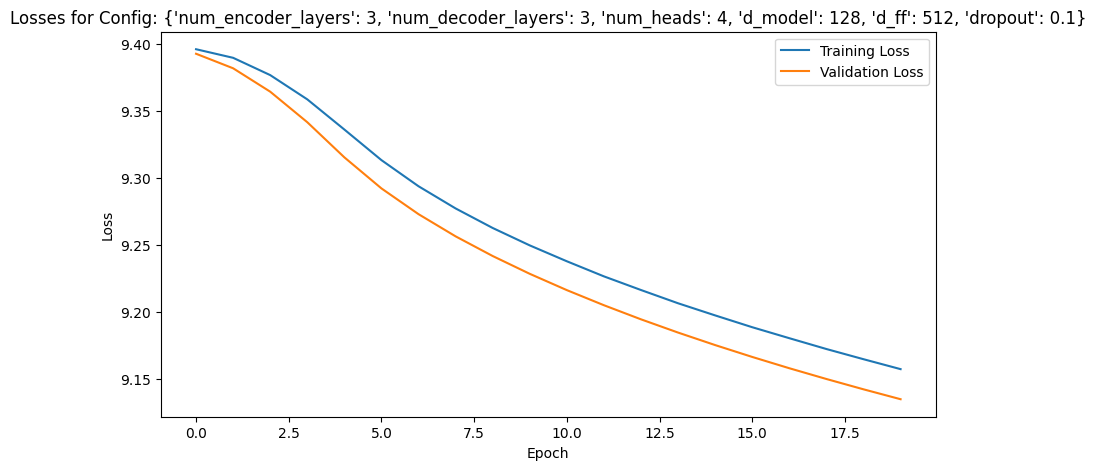

Overall BLEU Score for config {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'num_heads': 4, 'd_model': 128, 'd_ff': 512, 'dropout': 0.1}: 0.16563672945070157
Training with config: {'num_encoder_layers': 4, 'num_decoder_layers': 4, 'num_heads': 8, 'd_model': 256, 'd_ff': 1024, 'dropout': 0.2}
[4E-4D-8H-256EMB-1024FFN-0.2DR] Epoch 1, Training Loss: 9.4268, Validation Loss: 9.4186
[4E-4D-8H-256EMB-1024FFN-0.2DR] Epoch 2, Training Loss: 9.4117, Validation Loss: 9.3893
[4E-4D-8H-256EMB-1024FFN-0.2DR] Epoch 3, Training Loss: 9.3815, Validation Loss: 9.3421
[4E-4D-8H-256EMB-1024FFN-0.2DR] Epoch 4, Training Loss: 9.3396, Validation Loss: 9.2841
[4E-4D-8H-256EMB-1024FFN-0.2DR] Epoch 5, Training Loss: 9.2902, Validation Loss: 9.2262
[4E-4D-8H-256EMB-1024FFN-0.2DR] Epoch 6, Training Loss: 9.2446, Validation Loss: 9.1826
[4E-4D-8H-256EMB-1024FFN-0.2DR] Epoch 7, Training Loss: 9.2106, Validation Loss: 9.1509
[4E-4D-8H-256EMB-1024FFN-0.2DR] Epoch 8, Training Loss: 9.1839, Validation Loss: 9.125

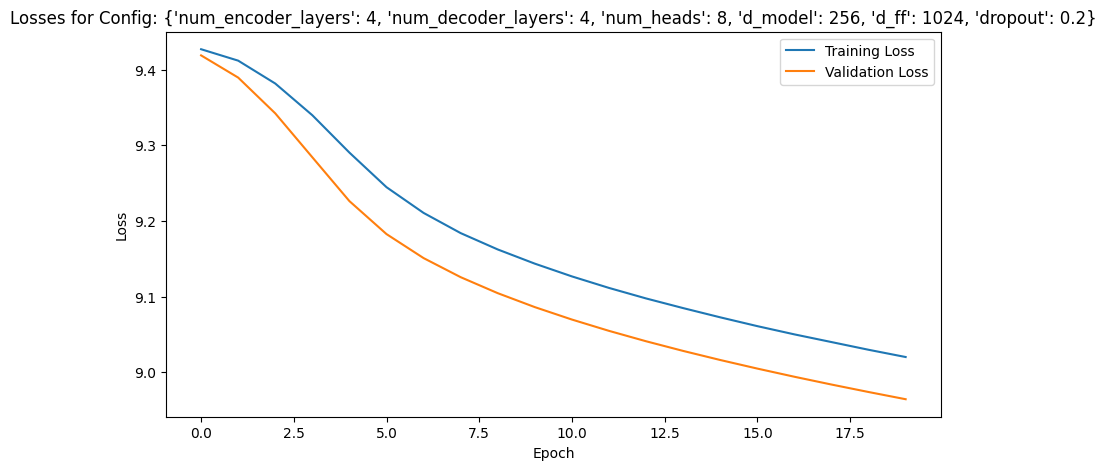

Overall BLEU Score for config {'num_encoder_layers': 4, 'num_decoder_layers': 4, 'num_heads': 8, 'd_model': 256, 'd_ff': 1024, 'dropout': 0.2}: 0.16556283423928111
Training with config: {'num_encoder_layers': 6, 'num_decoder_layers': 6, 'num_heads': 16, 'd_model': 512, 'd_ff': 2048, 'dropout': 0.3}
[6E-6D-16H-512EMB-2048FFN-0.3DR] Epoch 1, Training Loss: 9.4535, Validation Loss: 9.4393
[6E-6D-16H-512EMB-2048FFN-0.3DR] Epoch 2, Training Loss: 9.4137, Validation Loss: 9.3496
[6E-6D-16H-512EMB-2048FFN-0.3DR] Epoch 3, Training Loss: 9.3378, Validation Loss: 9.2171
[6E-6D-16H-512EMB-2048FFN-0.3DR] Epoch 4, Training Loss: 9.2427, Validation Loss: 9.0870
[6E-6D-16H-512EMB-2048FFN-0.3DR] Epoch 5, Training Loss: 9.1508, Validation Loss: 8.9815
[6E-6D-16H-512EMB-2048FFN-0.3DR] Epoch 6, Training Loss: 9.0751, Validation Loss: 8.9077
[6E-6D-16H-512EMB-2048FFN-0.3DR] Epoch 7, Training Loss: 9.0204, Validation Loss: 8.8559
[6E-6D-16H-512EMB-2048FFN-0.3DR] Epoch 8, Training Loss: 8.9776, Validation L

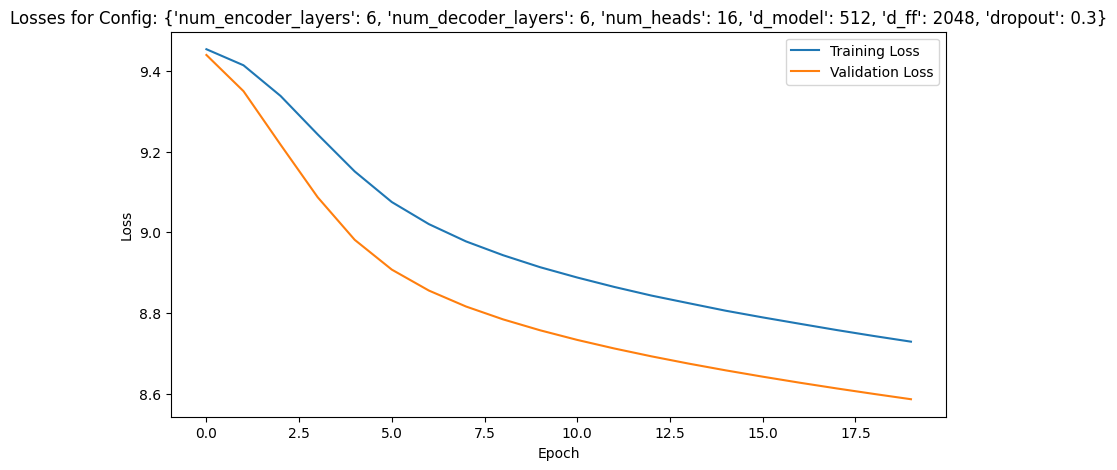

Overall BLEU Score for config {'num_encoder_layers': 6, 'num_decoder_layers': 6, 'num_heads': 16, 'd_model': 512, 'd_ff': 2048, 'dropout': 0.3}: 0.16505541804160698


In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import sentencepiece as spm
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

random.seed(42)
torch.manual_seed(42)
max_len = 50

base_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus'
train_en_path = os.path.join(base_path, 'train.en')
train_fr_path = os.path.join(base_path, 'train.fr')
dev_en_path = os.path.join(base_path, 'dev.en')
dev_fr_path = os.path.join(base_path, 'dev.fr')
test_en_path = os.path.join(base_path, 'test.en')
test_fr_path = os.path.join(base_path, 'test.fr')

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    return data

train_en = load_data(train_en_path)
train_fr = load_data(train_fr_path)
dev_en = load_data(dev_en_path)
dev_fr = load_data(dev_fr_path)
test_en = load_data(test_en_path)
test_fr = load_data(test_fr_path)

print(f"Number of English train sentences: {len(train_en)}")
print(f"Number of French train sentences: {len(train_fr)}")

sp_model_prefix_en = 'spm_en'
sp_model_prefix_fr = 'spm_fr'

with open('train_subset.en', 'w', encoding='utf-8') as f:
    f.write("".join(train_en))

with open('train_subset.fr', 'w', encoding='utf-8') as f:
    f.write("".join(train_fr))

spm.SentencePieceTrainer.train(
    input='train_subset.en', 
    model_prefix=sp_model_prefix_en, 
    vocab_size=12000, 
    model_type='bpe',
    max_sentence_length=4096,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)

spm.SentencePieceTrainer.train(
    input='train_subset.fr', 
    model_prefix=sp_model_prefix_fr, 
    vocab_size=12000, 
    model_type='bpe',
    max_sentence_length=4096,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)

sp_en = spm.SentencePieceProcessor(model_file=f'{sp_model_prefix_en}.model')
sp_fr = spm.SentencePieceProcessor(model_file=f'{sp_model_prefix_fr}.model')

def encode_sentence(sp, sentence):
    return [sp.bos_id()] + sp.encode(sentence, out_type=int) + [sp.eos_id()]

def filter_and_pad_sequences(source_sequences, target_sequences, pad_index, max_len):
    filtered_pairs = [(src, tgt) for src, tgt in zip(source_sequences, target_sequences) 
                      if len(src) <= max_len and len(tgt) <= max_len]
    if not filtered_pairs:
        return [], []
    source_sequences, target_sequences = zip(*filtered_pairs)
    
    source_padded = [src + [pad_index] * (max_len - len(src)) for src in source_sequences]
    target_padded = [tgt + [pad_index] * (max_len - len(tgt)) for tgt in target_sequences]
    
    return source_padded, target_padded

def create_pad_mask(seq, pad_index):
    return (seq != pad_index).unsqueeze(1).unsqueeze(2)

def create_tgt_mask(tgt, pad_index):
    tgt_pad_mask = (tgt != pad_index).unsqueeze(1).unsqueeze(2)
    seq_len = tgt.size(1)
    subsequent_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=tgt.device))
    subsequent_mask = subsequent_mask.unsqueeze(0).unsqueeze(1)
    tgt_mask = tgt_pad_mask & subsequent_mask
    return tgt_mask

class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data
        
    def __len__(self):
        return len(self.src_data)
        
    def __getitem__(self, index):
        return self.src_data[index], self.tgt_data[index]
    
train_en_indices = [encode_sentence(sp_en, sent) for sent in train_en]
train_fr_indices = [encode_sentence(sp_fr, sent) for sent in train_fr]
train_en_padded, train_fr_padded = filter_and_pad_sequences(train_en_indices, train_fr_indices, sp_en.pad_id(), max_len=50)
train_en_tensor = torch.tensor(train_en_padded, dtype=torch.long)
train_fr_tensor = torch.tensor(train_fr_padded, dtype=torch.long)
train_dataset = TranslationDataset(train_en_tensor, train_fr_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
    
    def attention(self, q, k, v, mask=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = F.softmax(scores, dim=-1)
        return torch.matmul(attn_weights, v)
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        q = self.q_linear(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        attn_output = self.attention(q, k, v, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_k * self.num_heads)
        return self.out_linear(attn_output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.encoder_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        attn_output = self.self_attention(x, x, x, tgt_mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        
        attn_output = self.encoder_attention(x, enc_output, enc_output, src_mask)
        x = x + self.dropout(attn_output)
        x = self.norm2(x)
        
        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.norm3(x)
        return x
    
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=sp_en.pad_id())
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    
    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=sp_fr.pad_id())
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.linear = nn.Linear(d_model, vocab_size)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return self.linear(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_encoder_layers, num_decoder_layers, num_heads, d_ff, dropout):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_encoder_layers, num_heads, d_ff, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_decoder_layers, num_heads, d_ff, dropout)
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        return dec_output

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0, std=math.sqrt(1.0 / module.embedding_dim))
        if module.padding_idx is not None:
            nn.init.constant_(module.weight[module.padding_idx], 0)
    elif isinstance(module, nn.LayerNorm):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

def noam_scheduler(step, warmup_steps, d_model):
    return (d_model ** -0.5) * min((step + 1) ** -0.5, (step + 1) * (warmup_steps ** -1.5))

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            src_mask = create_pad_mask(src, sp_en.pad_id()).to(device)
            tgt_mask = create_tgt_mask(tgt_input, sp_fr.pad_id()).to(device)
            output = model(src, tgt_input, src_mask, tgt_mask)
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.contiguous().view(-1)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    return total_loss / len(val_loader)

def calculate_bleu(model, test_loader, sp_fr, fr_idx2word):
    model.eval()
    references = []
    hypotheses = []
    with torch.no_grad():
        for src, tgt in test_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            batch_size = src.size(0)
            src_mask = create_pad_mask(src, sp_en.pad_id()).to(device)
            tgt_input = torch.full((batch_size, 1), sp_fr.bos_id(), dtype=torch.long, device=device)
            for _ in range(max_len):
                tgt_mask = create_tgt_mask(tgt_input, sp_fr.pad_id()).to(device)
                output = model(src, tgt_input, src_mask, tgt_mask)
                next_token = output.argmax(dim=-1)[:, -1].unsqueeze(1)
                tgt_input = torch.cat((tgt_input, next_token), dim=1)
                if (next_token == sp_fr.eos_id()).all():
                    break
            for ref, hyp in zip(tgt.tolist(), tgt_input.tolist()):
                ref_tokens = [fr_idx2word[token] for token in ref if token not in [sp_fr.pad_id(), sp_fr.bos_id(), sp_fr.eos_id()]]
                hyp_tokens = [fr_idx2word.get(token, '<unk>') for token in hyp if token not in [sp_fr.pad_id(), sp_fr.bos_id(), sp_fr.eos_id()]]
                references.append([ref_tokens])
                hypotheses.append(hyp_tokens)
    smoothing_function = SmoothingFunction().method7
    if all(len(hyp) == 0 for hyp in hypotheses):
        bleu_score = 0.0
    else:
        bleu_score = corpus_bleu(
            references,
            hypotheses,
            smoothing_function=smoothing_function,
            auto_reweigh=True
        )
    return bleu_score

def prepare_dataset(en_sentences, fr_sentences, sp_en, sp_fr):
    en_indices = [encode_sentence(sp_en, sent) for sent in en_sentences]
    fr_indices = [encode_sentence(sp_fr, sent) for sent in fr_sentences]
    en_padded, fr_padded = filter_and_pad_sequences(en_indices, fr_indices, sp_en.pad_id(), max_len)
    en_tensor = torch.tensor(en_padded, dtype=torch.long)
    fr_tensor = torch.tensor(fr_padded, dtype=torch.long)
    dataset = TranslationDataset(en_tensor, fr_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    return loader

dev_loader = prepare_dataset(dev_en, dev_fr, sp_en, sp_fr)
test_loader = prepare_dataset(test_en, test_fr, sp_en, sp_fr)
def train_and_evaluate_model(num_encoder_layers, num_decoder_layers, num_heads, d_model, d_ff, dropout):
    model = Transformer(
        sp_en.vocab_size(), sp_fr.vocab_size(),
        d_model=d_model,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        num_heads=num_heads,
        d_ff=d_ff,
        dropout=dropout
    ).to(device)
    model.apply(initialize_weights)
    learning_rate = 0.0001 
    warmup_steps = 4000     
    epochs = 20 
    criterion = nn.CrossEntropyLoss(ignore_index=sp_fr.pad_id())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda step: noam_scheduler(step, warmup_steps, d_model))
    train_losses = []
    val_losses = []  
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for step, (src, tgt) in enumerate(train_loader):
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            src_mask = create_pad_mask(src, sp_en.pad_id()).to(device)
            tgt_mask = create_tgt_mask(tgt_input, sp_fr.pad_id()).to(device)
            optimizer.zero_grad()
            output = model(src, tgt_input, src_mask, tgt_mask)
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.contiguous().view(-1)
            loss = criterion(output, tgt_output)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        val_loss = evaluate(model, dev_loader, criterion) 
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)    
        print(f"[{num_encoder_layers}E-{num_decoder_layers}D-{num_heads}H-{d_model}EMB-{d_ff}FFN-{dropout}DR] "
              f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    overall_bleu_score = calculate_bleu(model, test_loader, sp_fr, fr_idx2word) 
    return train_losses, val_losses, overall_bleu_score
fr_idx2word = {idx: sp_fr.id_to_piece(idx) for idx in range(sp_fr.vocab_size())}
hyperparameter_configs = [
    {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'num_heads': 4, 'd_model': 128, 'd_ff': 512, 'dropout': 0.1},
    {'num_encoder_layers': 4, 'num_decoder_layers': 4, 'num_heads': 8, 'd_model': 256, 'd_ff': 1024, 'dropout': 0.2},
    {'num_encoder_layers': 6, 'num_decoder_layers': 6, 'num_heads': 16, 'd_model': 512, 'd_ff': 2048, 'dropout': 0.3}
]
results = []
for config in hyperparameter_configs:
    print(f"Training with config: {config}")
    train_losses, val_losses, bleu_score = train_and_evaluate_model(**config)
    results.append({
        'config': config,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'bleu_score': bleu_score
    })
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Losses for Config: {config}")
    plt.show()

    print(f"Overall BLEU Score for config {config}: {bleu_score}")
